In [3]:
%load_ext autoreload
%autoreload 2

In [41]:
import requests
import pandas as pd
import json
#from sample_utilities import samples
#import stober_synthesis_utils as stober


import numpy as np
from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'science_jubilee'

## Next sample testing

In [3]:
# get proposed next sample from server in volume fractions
url = 'http://127.0.0.1:5000/get_proposed_candidates'
r = requests.get(url)

In [20]:
candidates = r.json()

In [23]:
candidate_samples = [cand['id'] for cand in candidates]

In [24]:
synthesized_samples

['fa77b3b1-98d1-454a-b9ad-0fa2d1587d90']

In [25]:
# check if sample already synthesized:
with open('APS/synthesized_samples.txt', 'rt') as f:
    synthesized_samples = [line.rstrip() for line in f]

In [26]:
unmade_samples = []
for candidate in candidate_samples:
    if candidate not in synthesized_samples:
        unmade_samples.append(candidate)

In [27]:
unmade_samples

['fa77b3b1-98d1-454a-b9ad-0fa2d1587d90']

In [4]:
candidate_volfracs = r.json()

teos_vol_frac = candidate_volfracs['teos_vf']
ethanol_vol_frac = candidate_volfracs['ethanol_vf']
ammonia_vol_frac = candidate_volfracs['ammonia_vf']
water_vol_frac = candidate_volfracs['water_vf']
ctab_mass_conc = candidate_volfracs['ctab_mass']
f127_mass_conc = candidate_volfracs['f127_mass']

In [5]:
with open('APS/Mesoporous_consants_APS.json', 'rt') as f:
    constants = json.load(f)

In [6]:
target_volume = 10000

In [7]:
sample = samples.MesoporousSample(target_volume, 'APS/Mesoporous_consants_APS.json', teos_vol_frac=teos_vol_frac, ammonia_vol_frac=ammonia_vol_frac, water_vol_frac=water_vol_frac, ethanol_vol_frac=ethanol_vol_frac, ctab_mass=ctab_mass_conc, f127_mass=f127_mass_conc)

In [8]:
sample.calculate_reactant_volumes()

20271.13030721668


In [9]:
sample.ammonia_volume

7266.651606849911

In [10]:
composition_dict = {
    'teos_volume':sample.teos_volume,
    'ammonia_volume':sample.ammonia_volume,
    'water_volume':sample.water_volume,
    'ethanol_volume':sample.ethanol_volume,
    'ctab_volume':sample.ctab_volume,
    'f127_volume':sample.f127_volume
}


In [11]:
composition_dict

{'teos_volume': 23961.84643399741,
 'ammonia_volume': 7266.651606849911,
 'water_volume': -462100.10958654486,
 'ethanol_volume': -20085.21510357986,
 'ctab_volume': 345500.6992364677,
 'f127_volume': 118694.23949062653}

In [7]:
stober.get_next_sample('APS/Mesoporous_consants_APS.json', 'APS/systemconfig.json', 'APS/synthesized_samples.txt')

Multiple samples proposed: {'a170e436-31ca-4c54-b2db-fdd24656491a': {'ammonia_vf': 0.4856307091532047, 'ap_distance': None, 'ctab_mass': 0.8209155282800259, 'ethanol_vf': 0.9818360779058918, 'f127_mass': 0.9405127225825316, 'id': 'a170e436-31ca-4c54-b2db-fdd24656491a', 'sample_order': 4, 'scattering_fp': None, 'status': 'proposed', 'teos_vf': 0.26258516951168187, 'water_vf': 0.5124985547683957}, 'b0d0c386-0d23-4a4c-a4f9-610947d74181': {'ammonia_vf': 0.9296956645293045, 'ap_distance': None, 'ctab_mass': 0.31745541696032076, 'ethanol_vf': 0.8279989583724159, 'f127_mass': 0.7261850422729071, 'id': 'b0d0c386-0d23-4a4c-a4f9-610947d74181', 'sample_order': 5, 'scattering_fp': None, 'status': 'proposed', 'teos_vf': 0.6115540332113789, 'water_vf': 0.18989837998369707}}
13841.993755300402


('a170e436-31ca-4c54-b2db-fdd24656491a',
 {'teos_volume': 7483.677331082933,
  'ammonia_volume': 13840.475210866334,
  'water_volume': -730254.577822173,
  'ethanol_volume': -4023.6329762414844,
  'ctab_volume': 547277.0188533505,
  'f127_volume': 188102.5445165063})

## Figure out mesoporous processing pipeline

smoke test with some mesoporous MAXS data. Not sure if we will need to merge at APS

In [3]:
background_fp = '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04214_G7-T2_Ethanol_background_000.dat'
data_fp = '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04233_H5-T2_5cc4_actually_000.dat'


In [52]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003

n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.


# hi q /low q split for analysis
q_split_hilo = 0.02
q_max_spl = q_split_hilo

In [53]:
# calculate target data 

In [54]:
target_r_nm = 350
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

In [55]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

amplitude_weight = 0.1

In [56]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

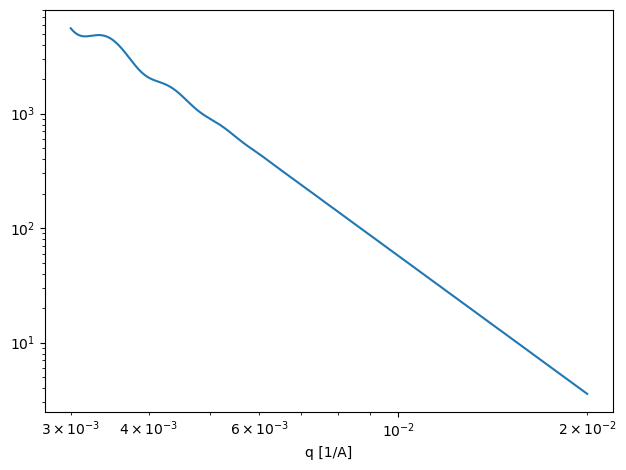

In [57]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')
#ax.set_title('120nm, 0.08 PDI target scattering')
plt.tight_layout()

In [58]:
# load data and background

In [59]:
data = io.read_1D_data(data_fp)
background = io.read_1D_data(background_fp)

In [60]:
# subtract

In [61]:
subtracted = subtract.chop_subtract(data[0], background[0], hiq_thresh=1)

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


In [62]:
subtracted = subtracted[subtracted['q'] < q_max_subtract]
subtracted = subtracted[~subtracted['I'].isna()]
subtracted = subtracted[subtracted['I'] > 0] # drop negative values 

In [63]:
# Split q at point

In [64]:
subtracted_loq = subtracted[subtracted['q'] < q_split_hilo]
subtracted_hiq = subtracted[subtracted['q'] > q_split_hilo]

In [67]:
# Spline fit for AP dist on lo q

In [69]:
q_log = np.log10(subtracted_loq['q'].to_numpy())
I_log = np.log10(subtracted_loq['I'].to_numpy())

I_savgol = manipulate.denoise_intensity(I_log, savgol_n = savgol_n, savgol_order = savgol_order)
I_spline = manipulate.fit_interpolate_spline(q_log, I_savgol, q_grid, s = s, k = k)

# scale onto target 
I_scaled = manipulate.scale_intensity_highqavg(I_spline, target_I, n_avg = n_avg)

-0.6254945412899899
-1.0639926142302658
593


In [13]:
# ap-distance for low q

In [71]:
amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)

In [72]:
amplitude

np.float64(1.1169619884456718)

In [73]:
phase

np.float64(0.9360451605774398)

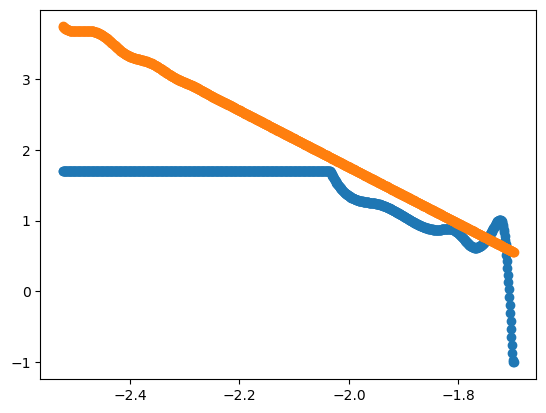

In [70]:
plt.scatter(q_grid, I_scaled)
plt.scatter(q_grid, target_I)

In [ ]:
# integrate high q

In [77]:
hiq_peak = np.trapezoid(subtracted_hiq['I'], x = subtracted_hiq['q'])

In [78]:
hiq_peak

np.float64(0.00020831270984632389)

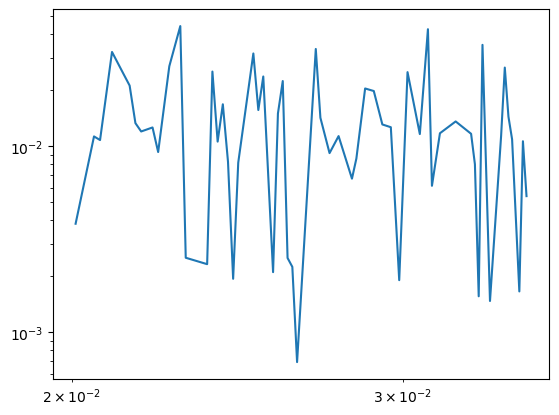

In [75]:
plt.loglog(subtracted_hiq['q'], subtracted_hiq['I'])

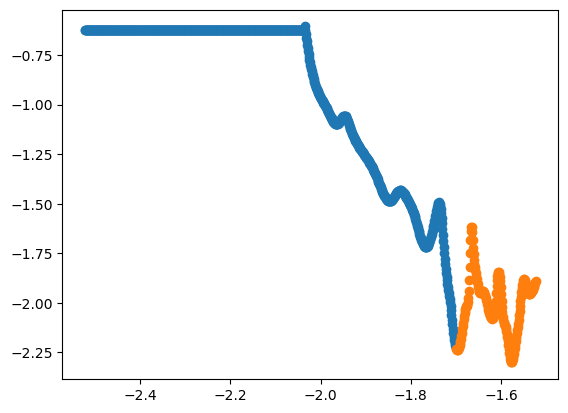

In [46]:
fig, ax = plt.subplots()

ax.scatter(q_grid_loq, I_loq)
ax.scatter(q_grid_hiq, I_hiq)

## Test out served workflow


In [81]:
# get next sample

url = 'http://127.0.0.1:5000/propose_new_candidates'
r = requests.get(url)

<Response [200]>

In [83]:
url = 'http://127.0.0.1:5000/get_proposed_candidates'
r = requests.get(url)

In [85]:
r.content

b'[\n  {\n    "ammonia_vf": 0.2904223899209424,\n    "amplitude_distance": null,\n    "background_fp": null,\n    "ctab_mass": 0.04048002783200744,\n    "ethanol_vf": 0.5049085615376188,\n    "f127_mass": 0.20383578896611798,\n    "hiq_peak": null,\n    "id": "51cb7eae-5ff4-4c1c-8066-a60971f7f6e6",\n    "phase_distance": null,\n    "sample_order": 1,\n    "scattering_fp": null,\n    "status": "proposed",\n    "teos_vf": 0.5937569721051884,\n    "water_vf": 0.09605360864173018\n  }\n]\n'

### upload background

In [95]:
url = 'http://127.0.0.1:5000/upload_background'
file_path = '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04214_G7-T2_Ethanol_background_000.dat'


with open(file_path, 'rb') as f:
    files = {'file':f}
    data = {'id':'bckg'}
    response = requests.post(url, files = files, json = data)

In [96]:
response.content

b'{\n  "file_path": "background/04214_G7-T2_Ethanol_background_000.dat",\n  "message": "Background file uploaded successfully"\n}\n'

### submit data for new sample

In [97]:
sample_id = r.json()[0]['id']

In [98]:
sample_id

'51cb7eae-5ff4-4c1c-8066-a60971f7f6e6'

In [172]:

url = 'http://127.0.0.1:5000/update_data'
background_filename = '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04214_G7-T2_Ethanol_background_000.dat'
data_fp = '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04233_H5-T2_5cc4_actually_000.dat'
json_data = {'id':sample_id, 'background_filename':background_filename, 'status':'unprocessed'}

with open(data_fp, 'rb') as f:
    files = {'data_file': f}
    data = {'data': json.dumps(json_data)}
    response = requests.post(url, files=files, data=data)

In [173]:
response.content

b'{\n  "data": {\n    "background_filename": "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04214_G7-T2_Ethanol_background_000.dat",\n    "background_fp": "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04214_G7-T2_Ethanol_background_000.dat",\n    "id": "51cb7eae-5ff4-4c1c-8066-a60971f7f6e6",\n    "status": "unprocessed"\n  },\n  "file_path": "data/04233_H5-T2_5cc4_actually_000.dat",\n  "message": "Sample updated successfully"\n}\n'

### run processing

In [180]:
url = 'http://127.0.0.1:5000/process_data'
r = requests.get(url)

In [178]:
r

<Response [200]>

In [179]:
r.content

b'{\n  "message": "Data processing started",\n  "task_id": "ebce8a0a-429c-49d9-9be2-51b2272812bf"\n}\n'

In [160]:
with open('/home/bgpelkie/Code/silica-np-synthesis/APS/systemconfig.json', 'r') as f:
    config = json.load(f)

In [162]:
config['processing_constants']

{'q_min_subtract': 0.002,
 'q_max_subtract': 0.035,
 'q_min_spl': 0.003,
 'n_interpolate_gridpts': 1001,
 'q_split_hilo': 0.02,
 'target_r_nm': 350,
 'target_pdi': 0.08,
 'sld_silica': 8.575,
 'sld_ethanol': 9.611,
 'savgol_n': 15,
 'savgol_order': 3,
 'min_data_len': 100,
 'spline_s': 0.05,
 'spline_k': 3,
 'scale_n_avg': 100,
 'apdist_optim': 'DP',
 'apdist_grid_dim': 10}

In [181]:
url = 'http://127.0.0.1:5000/get_sample'
data = {'id':'51cb7eae-5ff4-4c1c-8066-a60971f7f6e6'}
r = requests.post(url, json = data)

In [182]:
r

<Response [200]>

In [183]:
r.content

b'[\n  {\n    "ammonia_vf": 0.2904223899209424,\n    "amplitude_distance": 1.116961988445672,\n    "background_fp": "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04214_G7-T2_Ethanol_background_000.dat",\n    "ctab_mass": 0.04048002783200744,\n    "ethanol_vf": 0.5049085615376188,\n    "f127_mass": 0.20383578896611798,\n    "hiq_peak": 0.00020831270984632389,\n    "id": "51cb7eae-5ff4-4c1c-8066-a60971f7f6e6",\n    "phase_distance": 0.9360451605774398,\n    "sample_order": 1,\n    "scattering_fp": "data/04233_H5-T2_5cc4_actually_000.dat",\n    "status": "processed",\n    "teos_vf": 0.5937569721051884,\n    "water_vf": 0.09605360864173018\n  }\n]\n'

In [48]:
url = 'http://127.0.0.1:5000/dump_to_csv'
r = requests.get(url)

## Full integration testing

In [1]:
# make sobol samples

In [36]:
url = 'http://127.0.0.1:5000/generate_sobol_baseline'
r = requests.get(url)

In [37]:
r

<Response [200]>

In [38]:
r.content

b'{\n  "message": "Sobol baseline samples generated"\n}\n'

In [86]:
url = 'http://127.0.0.1:5000/get_proposed_candidates'
r = requests.get(url)

In [87]:
r.content

b'[\n  {\n    "ammonia_vf": 0.10000000149011612,\n    "amplitude_distance": null,\n    "background_fp": null,\n    "ctab_mass": 0.004999999888241291,\n    "ethanol_vf": 0.004999999888241291,\n    "f127_mass": 0.10000000149011612,\n    "hiq_peak": null,\n    "id": "415f942f-453b-4814-9a60-4d378ff69c3a",\n    "phase_distance": null,\n    "sample_order": 35,\n    "scattering_fp": null,\n    "status": "proposed",\n    "teos_vf": 0.10000000149011612,\n    "water_vf": 0.6899999380111694\n  }\n]\n'

In [88]:
proposed_samples = r.json()

In [89]:
proposed_samples

[{'ammonia_vf': 0.10000000149011612,
  'amplitude_distance': None,
  'background_fp': None,
  'ctab_mass': 0.004999999888241291,
  'ethanol_vf': 0.004999999888241291,
  'f127_mass': 0.10000000149011612,
  'hiq_peak': None,
  'id': '415f942f-453b-4814-9a60-4d378ff69c3a',
  'phase_distance': None,
  'sample_order': 35,
  'scattering_fp': None,
  'status': 'proposed',
  'teos_vf': 0.10000000149011612,
  'water_vf': 0.6899999380111694}]

In [79]:
for sample in proposed_samples:
    url = 'http://127.0.0.1:5000/update_data'
    background_filename = '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04214_G7-T2_Ethanol_background_000.dat'
    data_fp = '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_03_22_MesoporousVolumeTesting/04233_H5-T2_5cc4_actually_000.dat'
    json_data = {'id':sample['id'], 'background_filename':background_filename, 'status':'unprocessed'}
    
    with open(data_fp, 'rb') as f:
        files = {'data_file': f}
        data = {'data': json.dumps(json_data)}
        response = requests.post(url, files=files, data=data)
        

In [80]:
response

<Response [200]>

In [81]:
url = 'http://127.0.0.1:5000/process_data'
r = requests.get(url)

In [49]:
r

<Response [200]>

In [84]:
url = 'http://127.0.0.1:5000/propose_new_candidates'
r = requests.get(url)

In [85]:
r

<Response [200]>

In [67]:
import torch

In [72]:
float(torch.tensor([[0.0050, 0.0050, 0.1000, 0.1000, 0.0050]])[0][4])

0.004999999888241291